### Step 1: Problem statement

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

In [80]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import catboost

### Step 2: Collecting data

In this step we will import required libraries and data from csv files.

In [31]:
# Importing all datasets
TitanicDataTr = pd.read_csv("train.csv")
TitanicDataTs = pd.read_csv("test.csv")

### Step 3: Exploratory data analysis

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

In [32]:
TitanicDataTr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Definition | Key |
| --- | --- | --- |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| survival | Survival | 0 = No, 1 = Yes |
| sex | Sex | Male/Female |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |	

In [33]:
TitanicDataTr.groupby(TitanicDataTr['Survived']).count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [39]:
ColumnUnique = pd.DataFrame(columns=['Count'])
for i in TitanicDataTr.columns:
    ColumnUnique.loc[i]=[TitanicDataTr[i].value_counts().count()]
ColumnUnique.sort_values(by = "Count", ascending = False,inplace=True)

ColumnType=pd.DataFrame(TitanicDataTr.dtypes,columns=['Dtype'])
pd.merge(ColumnUnique,ColumnType,left_index=True,right_index=True)

,Count,Dtype
PassengerId,891,int64
Name,891,object
Ticket,681,object
Fare,248,float64
Cabin,147,object
Age,88,float64
SibSp,7,int64
Parch,7,int64
Pclass,3,int64
Embarked,3,object


In [35]:
# # Outlier detection 
# from collections import Counter

# def detect_outliers(df,n,features):
#     """
#     Takes a dataframe df of features and returns a list of the indices
#     corresponding to the observations containing more than n outliers according
#     to the Tukey method."""
#     outlier_indices = []
    
#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(df[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(df[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers

# # detect outliers from Age, SibSp , Parch and Fare
# Outliers_to_drop = detect_outliers(TitanicDataTr,2,["Age","SibSp","Parch","Fare"])
# print("percent of data with outliers values:", round((TitanicDataTr.loc[Outliers_to_drop].shape[0]/TitanicDataTr.shape[0])*100,2),"%",sep="")

In [36]:
# TitanicDataTr.drop(Outliers_to_drop,axis=0, inplace=True)

In [37]:
TitanicData=pd.concat([TitanicDataTr, TitanicDataTs], ignore_index=True)

## Dealing with missing values ##

In [38]:
TitanicData.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

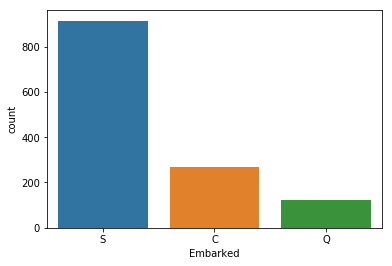

In [40]:
sns.countplot(x="Embarked",data=TitanicData)

In [41]:
TitanicData['Embarked'].fillna(TitanicData['Embarked'].value_counts().index[0],inplace=True)

(-15, 522.3292)

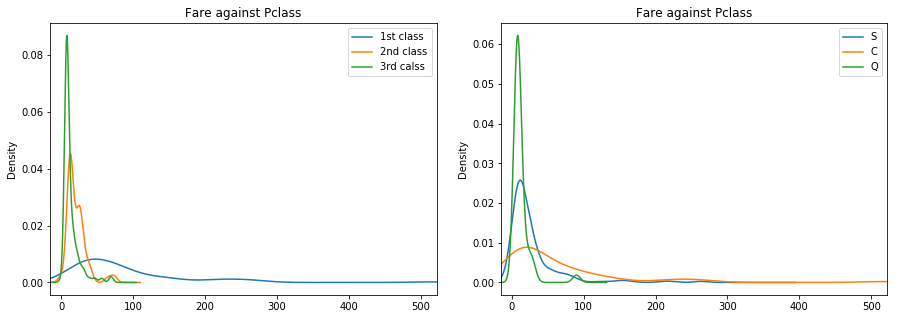

In [42]:
fig=plt.figure(figsize=(15,5))
plt.subplot2grid((1,4),(0,0),colspan=2)
fig.subplots_adjust(hspace=.5,wspace = 0.4)
for i in [1,2,3]:
    TitanicData.Fare[(TitanicData.Pclass==i) & (TitanicData.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("1st class","2nd class","3rd calss"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Fare.notnull())].max()+10)

plt.subplot2grid((1,4),(0,2),colspan=2)
for i in ["S","C","Q"]:
    TitanicData.Fare[(TitanicData.Embarked==i) & (TitanicData.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("S","C","Q"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Fare.notnull())].max()+10)

In [43]:
TitanicData['Fare'].fillna(TitanicData.groupby(["Pclass",'Embarked'])['Fare'].transform("median"),inplace=True)

In [44]:
TitanicData['Cabin']=TitanicData['Cabin'].str[0]

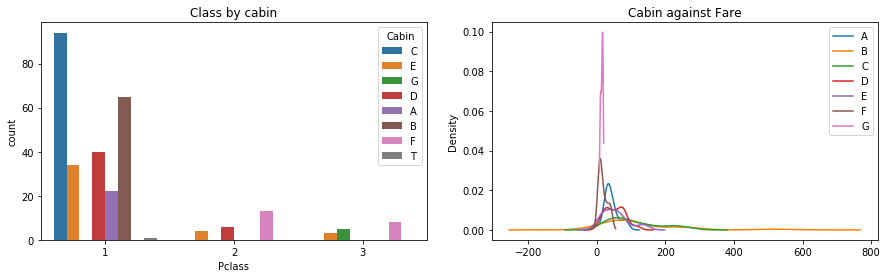

In [45]:
fig=plt.figure (figsize=(15,10))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

plt.subplot2grid((2,4),(0,0),colspan=2)
sns.countplot (x='Pclass', hue='Cabin',data=TitanicData)
plt.title("Class by cabin")

plt.subplot2grid((2,4),(0,2),colspan=2)
for i in ['A','B','C','D','E','F','G']:
    TitanicData.Fare[TitanicData.Cabin==i].plot(kind='kde')
plt.title("Cabin against Fare")
plt.legend(('A','B','C','D','E','F','G'))

In [46]:
TitanicData['Cabin']=TitanicData.groupby(['Pclass','Fare'])['Cabin'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Z"))

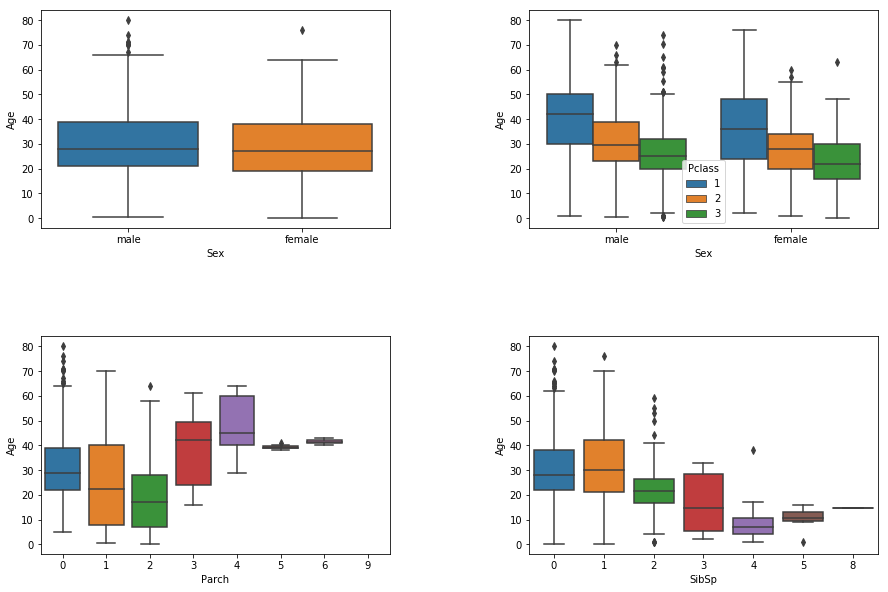

In [48]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(y="Age",x="Sex",data=TitanicData,kind="box",ax=ax[0])
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=TitanicData,kind="box",ax=ax[1])
g.set_ylabels("survival probability")
g = sns.factorplot(y="Age",x="Parch", data=TitanicData,kind="box",ax=ax[2])
g = sns.factorplot(y="Age",x="SibSp", data=TitanicData,kind="box",ax=ax[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

In [49]:
TitanicData["Title"]=(TitanicData["Name"].str.split(",", n = 1, expand = True))[1].str.split(".", n = 1, expand = True)[0]
TitanicData["Title"]=TitanicData["Title"].str.strip()

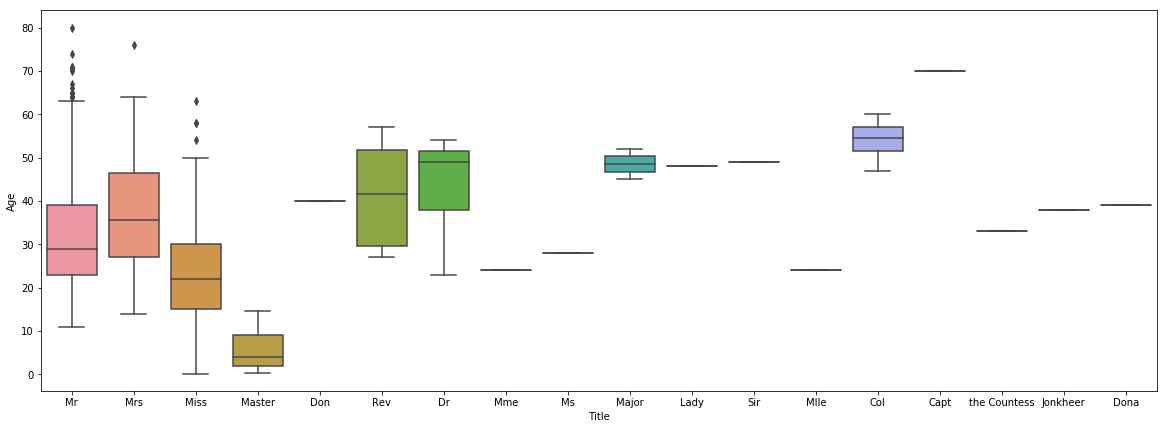

In [51]:
fig,ax=plt.subplots(figsize=(20,7))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(y="Age",x="Title",data=TitanicData,kind="box",ax=ax)
plt.tight_layout()
plt.close(2)

In [52]:
TitanicData["Title"]=TitanicData["Title"].apply(lambda x: 'Master' if x in ['Master'] else ('Miss' if x in ['Miss','Ms','Mile','Mme']
                                                                                    else ('Mrs' if x in ['Mrs','Lady','Dona','the Countess'] 
                                                                                    else ('Mr' if x in ['Mr','Sir','Don','Jonkheer'] 
                                                                                    else 'Others'))))

In [53]:
import math
AgeMedian=TitanicData['Age'].median()
TitanicData['Age']=TitanicData.groupby(['Pclass','SibSp','Parch','Title'])['Age'].transform(
    lambda x: x.fillna(x.median() if not math.isnan(x.median()) else AgeMedian))

In [54]:
TitanicDataTr=TitanicData[~TitanicData.Survived.isnull()]
TitanicDataTs=TitanicData[TitanicData.Survived.isnull()]

## Checking column behavior wrt survival data

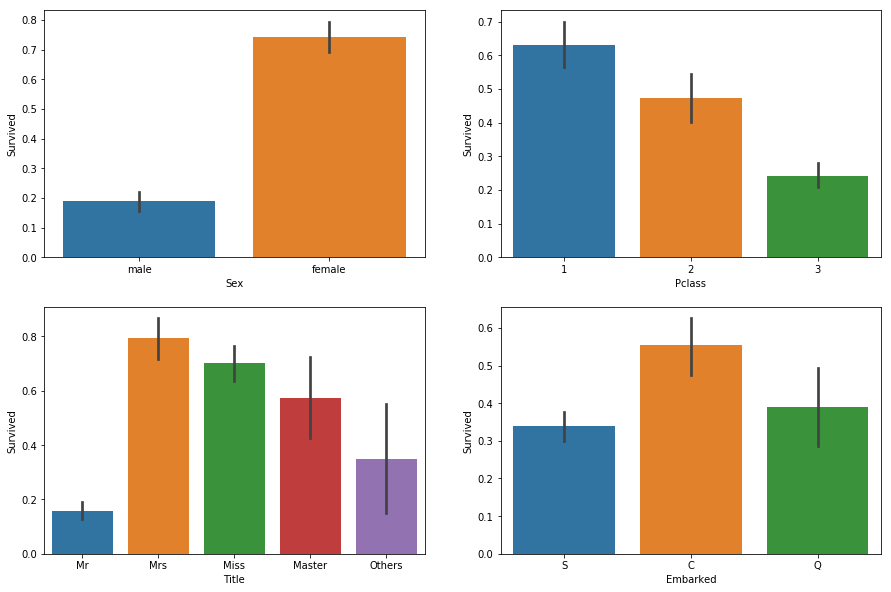

In [56]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
sns.factorplot(y="Survived",x="Sex",data=TitanicDataTr,kind="bar",ax=ax[0])
sns.factorplot(y="Survived",x="Pclass",data=TitanicDataTr,kind="bar",ax=ax[1])
sns.factorplot(y="Survived",x="Title",data=TitanicDataTr,kind="bar",ax=ax[2])
sns.factorplot(y="Survived",x="Embarked",data=TitanicDataTr,kind="bar",ax=ax[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

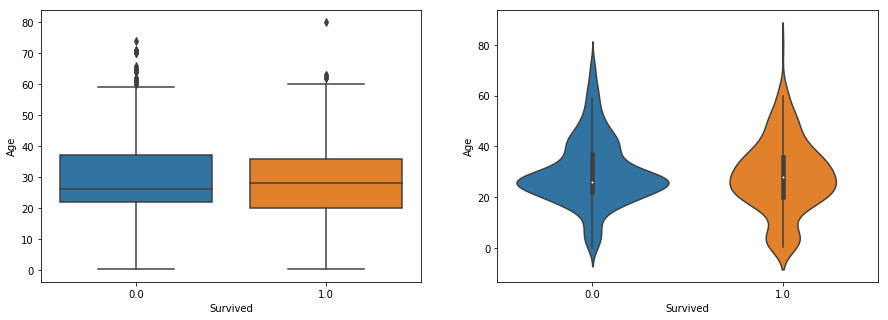

In [57]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(x="Survived", y = "Age",data = TitanicData, kind="box",ax=ax[0])
g = sns.factorplot(x="Survived", y = "Age",data = TitanicData, kind="violin",ax=ax[1])
plt.close(2)
plt.close(3)

(-15, 522.3292)

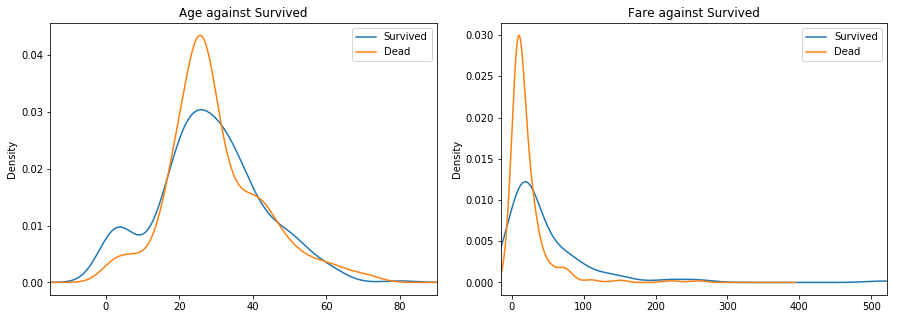

In [58]:
fig = plt.figure(figsize=(15,5 ))
plt.subplot2grid((1,4),(0,0),colspan=2)
fig.subplots_adjust(hspace=.5,wspace = 0.4)

for i in [1,0]:
    TitanicData.Age[(TitanicData.Survived==i) & (TitanicData.Survived.notnull())].plot(kind='kde')
plt.title("Age against Survived")
plt.legend(("Survived","Dead"))
plt.xlim(-15,TitanicData.Age[(TitanicData.Survived.notnull())].max()+10)

plt.subplot2grid((1,4),(0,2),colspan=2)
for i in [1,0]:
    TitanicData.Fare[(TitanicData.Survived==i) & (TitanicData.Survived.notnull())].plot(kind='kde')
plt.title("Fare against Survived")
plt.legend(("Survived","Dead"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Survived.notnull())].max()+10)

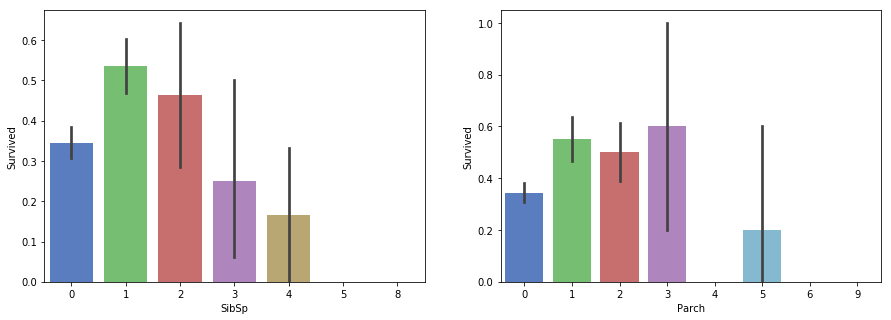

In [60]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

g=sns.factorplot(x="SibSp",y="Survived",data=TitanicData,kind="bar", size = 6 , palette = "muted",ax=ax[0])
g.despine(left=True)
g = g.set_ylabels("survival probability")

g  = sns.factorplot(x="Parch",y="Survived",data=TitanicData,kind="bar", size = 6 ,palette = "muted",ax=ax[1])
g.despine(left=True)
g = g.set_ylabels("survival probability")
plt.close(2)
plt.close(3)
# fig.show()

In [61]:
TitanicData["FamilySize"]=(TitanicData["SibSp"]+TitanicData["Parch"]+1)

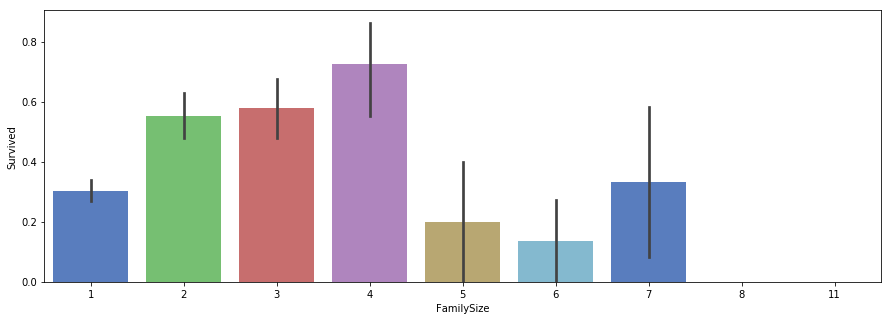

In [65]:
f,ax=plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

g=sns.factorplot(x="FamilySize",y="Survived",data=TitanicData,kind="bar", size = 6 , palette = "muted",ax=ax)
g.despine(left=True)
g = g.set_ylabels("survival probability")
plt.close(2)

In [66]:
# Create new feature of family size
TitanicData['Single'] = TitanicData['FamilySize'].map(lambda s: 1 if s == 1 else 0)
TitanicData['Small_F'] = TitanicData['FamilySize'].map(lambda s: 1 if  2 <= s <= 3  else 0)
TitanicData['Med_F'] = TitanicData['FamilySize'].map(lambda s: 1 if 4 <= s <= 4 else 0)
TitanicData['Large_F'] = TitanicData['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [134]:
# gender = {'male': 0,'female': 1} 
# TitanicData["Sex"]=TitanicData["Sex"].map(gender)

In [67]:
TitanicData["SurName"]=(TitanicData["Name"].str.split(",", n = 1, expand = True))[0]

In [68]:
TitanicData.set_index("PassengerId",inplace=True)

In [69]:
TitanicData=TitanicData[[c for c in TitanicData if c not in ['SurName', 'Ticket']] + ['SurName', 'Ticket']]
TitanicData.sort_values(['SurName', 'Ticket'],ascending=[True,True],inplace=True)

In [70]:
TitanicData['SurName|Ticket']=TitanicData['SurName'].map(str) + "|" + TitanicData['Ticket'].map(str)

In [72]:
DropList=['Name','FamilySize','SurName','Ticket']
TitanicData.drop(DropList,axis=1,inplace=True)

In [120]:
TitanicData.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Title', 'Single', 'Small_F', 'Med_F', 'Large_F',
       'SurName|Ticket'],
      dtype='object')

In [76]:
train=TitanicData[~TitanicData.Survived.isnull()]
test=TitanicData[TitanicData.Survived.isnull()]

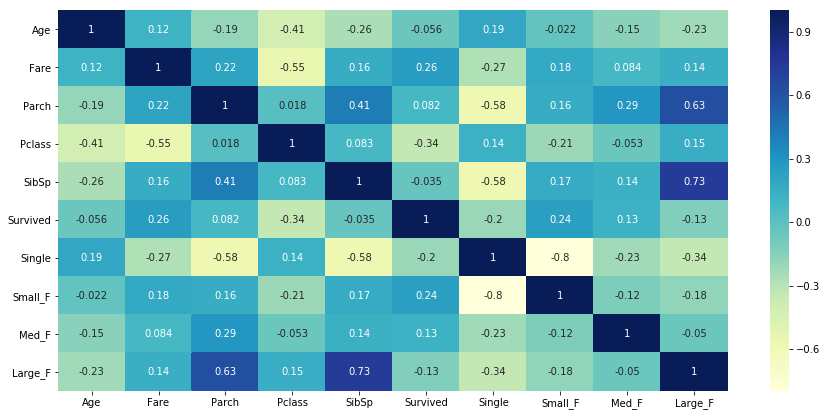

In [128]:
# we will plot a heatmap to look at the corelation in numerical form.
plt.figure(figsize=(15,7))
sns.heatmap(train.corr(),annot=True, cmap='YlGnBu')
plt.show()

In [96]:
# Build catboost model for prediction.
features = ['Cabin','Embarked','Pclass','Title','SurName|Ticket','Fare','Age','Single', 'Small_F','Med_F', 'Large_F']
X_train = train[features]
y_train = train['Survived']
X_test = test[features]

model = CatBoostClassifier(one_hot_max_size=4,iterations=100,random_seed=0,verbose=False,eval_metric='Accuracy')

pool = catboost.Pool(X_train, y_train, cat_features=[0, 1, 3, 4])
# print('To see the Catboost plots, fork this kernel and run it in the editing mode.')
cv_scores = catboost.cv(pool, model.get_params(), fold_count=10, plot=False)
print('CV score: {:.5f}'.format(cv_scores['test-Accuracy-mean'].values[-1]))

CV score: 0.83838


Text(0.5,1,'Catboost Feature Importance Ranking')

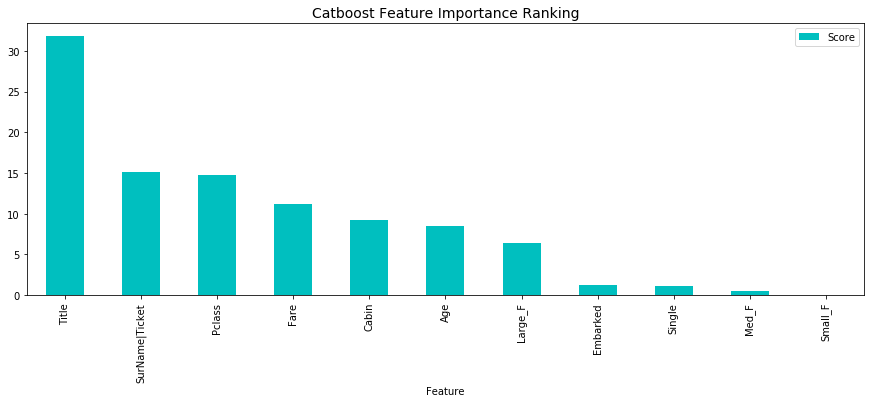

In [131]:
# Checking importance of features.
model.fit(X_train, y_train, cat_features=[0, 1, 3, 4])
f,ax=plt.subplots(figsize=(15,5))
feature_score=pd.DataFrame(list(zip(features,model.feature_importances_)),columns=['Feature','Score'])
feature_score.sort_values(by=["Score"],ascending=[False] ,inplace=True)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c',ax=ax)
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)


In [132]:
features = ['Title','SurName|Ticket','Pclass','Fare','Cabin']
X_train = train[features]
y_train = train['Survived']
X_test = test[features]

model = CatBoostClassifier(one_hot_max_size=4,iterations=100,random_seed=0,verbose=False,eval_metric='Accuracy')

pool = catboost.Pool(X_train, y_train, cat_features=[0, 1, 2, 4])
cv_scores = catboost.cv(pool, model.get_params(), fold_count=10, plot=False)
print('CV score: {:.5f}'.format(cv_scores['test-Accuracy-mean'].values[-1]))

CV score: 0.83725


Text(0.5,1,'Catboost Feature Importance Ranking')

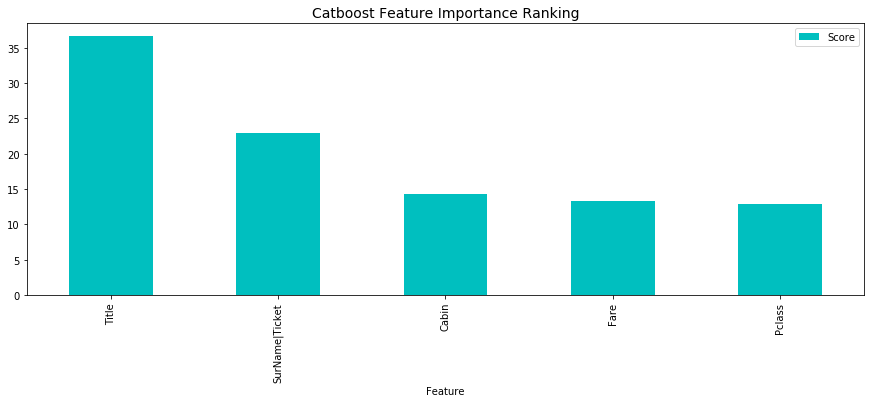

In [134]:
model.fit(X_train, y_train, cat_features=[0, 1, 2, 4])
f,ax=plt.subplots(figsize=(15,5))
feature_score=pd.DataFrame(list(zip(features,model.feature_importances_)),columns=['Feature','Score'])
feature_score.sort_values(by=["Score"],ascending=[False] ,inplace=True)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c',ax=ax)
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)

In [141]:
model.fit(pool)
pred = model.predict(X_test).astype('int')
Submission=pd.DataFrame(list(zip(test.index,pred)),columns=['PassengerId','Survived'])
Submission.sort_values(by=["PassengerId"],ascending=[False] ,inplace=True)

In [144]:
# Generating output
Submission.to_csv("New_Result.csv",index=False)